## Import Modules

In [12]:
import os
import sys

# CHANGE LEVELS:
chdir = os.path.dirname(os.getcwd())
sys.path.insert(0, chdir)

import numpy as np
from numpy.linalg import eig
from numpy import array, mean, cov, argsort, arange, linspace
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

# PYSOM LIBRARY MODULES:
import pysom
from pysom.node import Node
from pysom.graph import Graph
from pysom.nodes.bmu import BMU
from pysom.nodes.dist import Dist
from pysom.nodes.concat import Concat
from pysom.nodes.calibrate import Calibrate
from pysom.nodes.som import SOM, nhood_mexican, nhood_gaussian, nhood_bubble, dist_manhattan, dist_cosine

## Helper Plot Function

In [13]:
plt.rcParams["figure.figsize"] = (20, 10)

def plot_features(size, out):
    for bmu, labels in out.items():
        labels = list(labels)
        print(labels)

        for i in range(len(labels)):
            plt.text(bmu[0] + 0.1, bmu[1] + (i + 1) / len(labels) - 0.35, labels[i], fontsize=20)

    plt.xticks(np.arange(size + 1))
    plt.yticks(np.arange(size + 1))
    plt.grid()
    plt.show()

## Load Animal

In [14]:
animal = ['Dove', 'Chicken', 'Duck', 'Goose', 'Owl', 'Hawk', 'Eagle', 'Fox', 'Dog', 'Wolf', 'Cat', 'Tiger', 'Lion', 'Horse', 'Zebra', 'Cow']
features = [
    [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],    # Dove
    [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],    # Chicken
    [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],    # Duck
    [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1],    # Goose
    [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],    # Owl
    [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],    # Hawk
    [0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],    # Eagle
    [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0],    # Fox
    [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0],    # Dog
    [0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],    # Wolf
    [1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0],    # Cat
    [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0],    # Tiger
    [0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],    # Lion
    [0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0],    # Horse
    [0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0],    # Zebra
    [0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]     # Cow
]

feats = pd.DataFrame(features)
feats.columns = ['Small', 'Medium', 'Big', '2-legs', '4-legs', 'Hair', 'Hooves', 'Mane', 'Feathers', 'Hunt', 'Run', 'Fly', 'Swim']

data = array(feats.values)

## Deep SOM (1) - Groups Features (Hunt sent twice)

                 *--->som(size)->bmu(size)--->*
                 /                              \\
                /----->som(legs)->bmu(legs)------\\
    animal -> dist                          concat -> som -> calibrate(labels)
                \\---->som(char)->bmu(char)------/
                 \\                             /
                  \\-->som(hunt)->bmu(hunt)----/
                   \\                         /
                    *->som(move)->bmu(move)->*
                     (move doubles up on hunt)
  


* size = small(0), med(1), big(2) 
* legs = 2-legs(3), 4-legs(4) 
* char = hair(5), hooves(6), mane(7), feathers(8) 
* hunt = hunt(9) 
* move = hunt(9)*, run(10), fly(11), swim(12) 

### Deep SOM (1) - Using BMU weights w

['Dove']
['Chicken']
['Duck', 'Goose']
['Owl', 'Hawk']
['Eagle']
['Fox']
['Dog', 'Wolf']
['Cat']
['Tiger', 'Lion']
['Horse', 'Zebra']
['Cow']


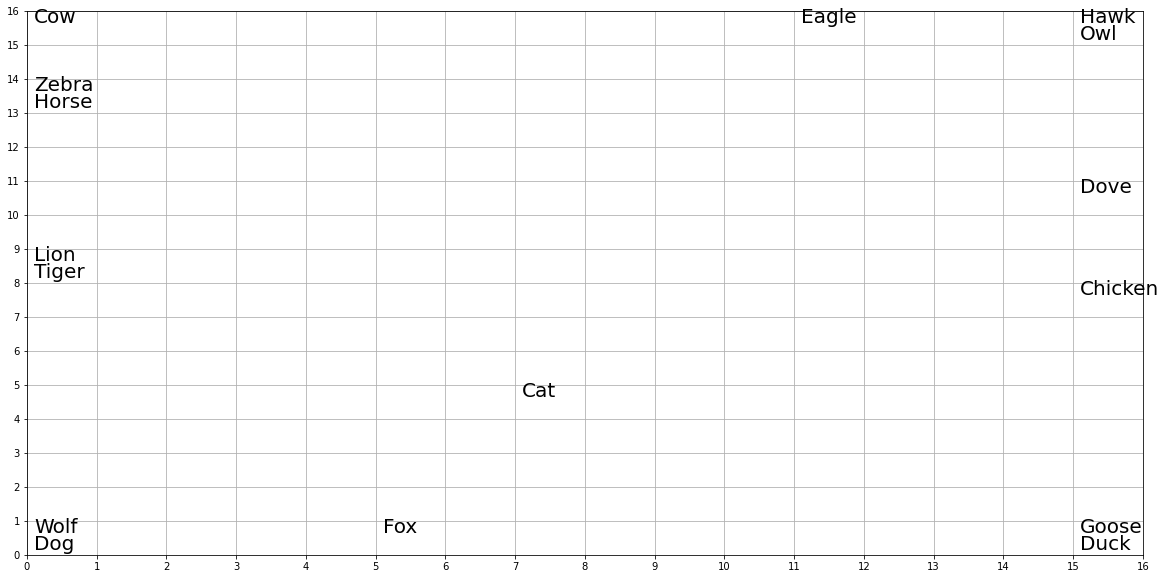

In [15]:
g = Graph()

sel = [(1, [0, 1, 2]), (1, [3, 4]), (1, [5, 6, 7, 8]), (1, [9]), (1, [9, 10, 11, 12])]

dist = g.create(Dist, props={"selections": sel})

g.connect(g.start, dist, 1)

som_size = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 3, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_legs = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 2, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_char = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 4, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_hunt = g.create(
    SOM, props={'norm': True, "size": 16, "dim": 1, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_move = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 4, "sigma": 13, "lr": 0.8, "n_iters": 10000})

g.connect(dist, som_size, 1)
g.connect(dist, som_legs, 2)
g.connect(dist, som_char, 3)
g.connect(dist, som_hunt, 4)
g.connect(dist, som_move, 5)

bmu_size = g.create(BMU, props={"output": "w"})
bmu_legs = g.create(BMU, props={"output": "w"})
bmu_char = g.create(BMU, props={"output": "w"})
bmu_hunt = g.create(BMU, props={"output": "w"})
bmu_move = g.create(BMU, props={"output": "w"})

g.connect(som_size, bmu_size, 0)
g.connect(som_legs, bmu_legs, 0)
g.connect(som_char, bmu_char, 0)
g.connect(som_hunt, bmu_hunt, 0)
g.connect(som_move, bmu_move, 0)

concat = g.create(Concat, props={"axis": 1})

g.connect(bmu_size, concat, 1)
g.connect(bmu_legs, concat, 1)
g.connect(bmu_char, concat, 1)
g.connect(bmu_hunt, concat, 1)
g.connect(bmu_move, concat, 1)

size = 16

som = g.create(SOM, props={'pca': True, 'norm': True, 'size': size, 'dim': 14,
               "nhood": nhood_gaussian, 'sigma': 13, 'lr': 0.8, 'n_iters': 10000})

g.connect(concat, som, 1)
cal = g.create(Calibrate, props={"labels": animal})

g.connect(som, cal, 0)
g.connect(cal, g.end, 1)

g.set_input(data)

out = g.get_output()

plot_features(size, out)

### Deep SOM (1) - Using BMU coords 2D (Gaussian Output SOM 16x16)

['Dove']
['Chicken']
['Duck', 'Goose']
['Owl', 'Hawk']
['Eagle']
['Fox']
['Dog']
['Wolf', 'Lion']
['Cat']
['Tiger']
['Horse', 'Zebra', 'Cow']


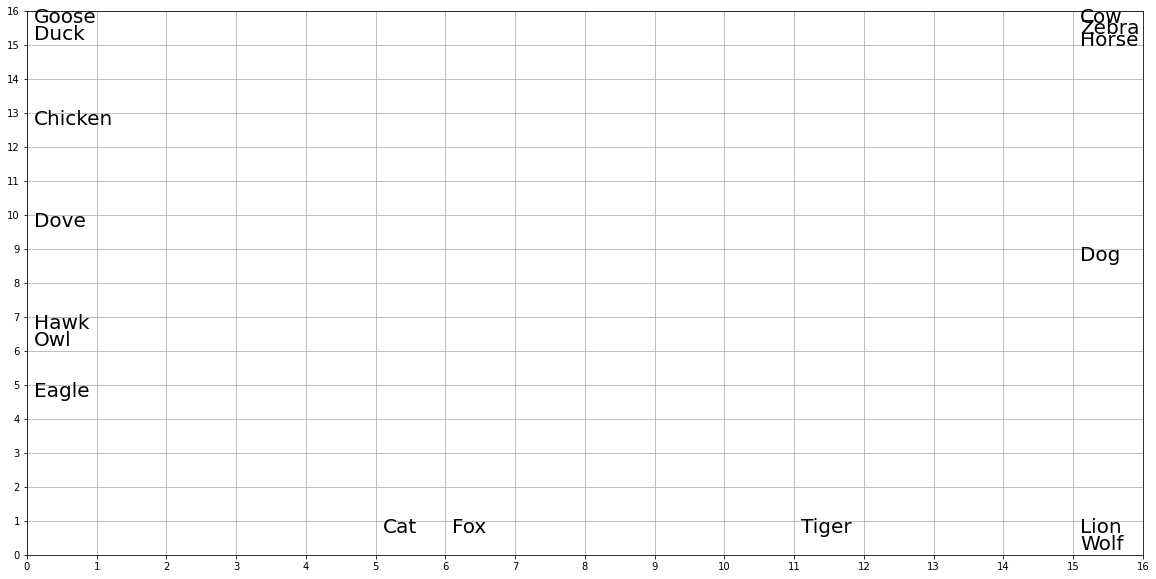

In [16]:
g = Graph()

sel = [(1, [0, 1, 2]), (1, [3, 4]), (1, [5, 6, 7, 8]), (1, [9]), (1, [9, 10, 11, 12])]

dist = g.create(Dist, props={"selections": sel})

g.connect(g.start, dist, 1)

som_size = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 3, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_legs = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 2, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_char = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 4, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_hunt = g.create(
    SOM, props={'norm': True, "size": 16, "dim": 1, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_move = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 4, "sigma": 13, "lr": 0.8, "n_iters": 10000})

g.connect(dist, som_size, 1)
g.connect(dist, som_legs, 2)
g.connect(dist, som_char, 3)
g.connect(dist, som_hunt, 4)
g.connect(dist, som_move, 5)

bmu_size = g.create(BMU, props={"output": "2D"})
bmu_legs = g.create(BMU, props={"output": "2D"})
bmu_char = g.create(BMU, props={"output": "2D"})
bmu_hunt = g.create(BMU, props={"output": "2D"})
bmu_move = g.create(BMU, props={"output": "2D"})

g.connect(som_size, bmu_size, 0)
g.connect(som_legs, bmu_legs, 0)
g.connect(som_char, bmu_char, 0)
g.connect(som_hunt, bmu_hunt, 0)
g.connect(som_move, bmu_move, 0)

concat = g.create(Concat, props={"axis": 1})

g.connect(bmu_size, concat, 1)
g.connect(bmu_legs, concat, 1)
g.connect(bmu_char, concat, 1)
g.connect(bmu_hunt, concat, 1)
g.connect(bmu_move, concat, 1)

size = 16

som = g.create(SOM, props={'pca': True, 'norm': True, 'size': size, 'dim': 10,
               "nhood": nhood_gaussian, 'sigma': 13, 'lr': 0.8, 'n_iters': 10000})

g.connect(concat, som, 1)
cal = g.create(Calibrate, props={"labels": animal})

g.connect(som, cal, 0)
g.connect(cal, g.end, 1)

g.set_input(data)

out = g.get_output()

plot_features(size, out)

### Deep SOM (1) - Using BMU indices 1D (Gaussian Output SOM 16x16) 

['Dove', 'Duck', 'Goose']
['Chicken', 'Dog']
['Owl', 'Hawk']
['Eagle']
['Fox', 'Wolf']
['Cat']
['Tiger', 'Lion']
['Horse', 'Zebra', 'Cow']


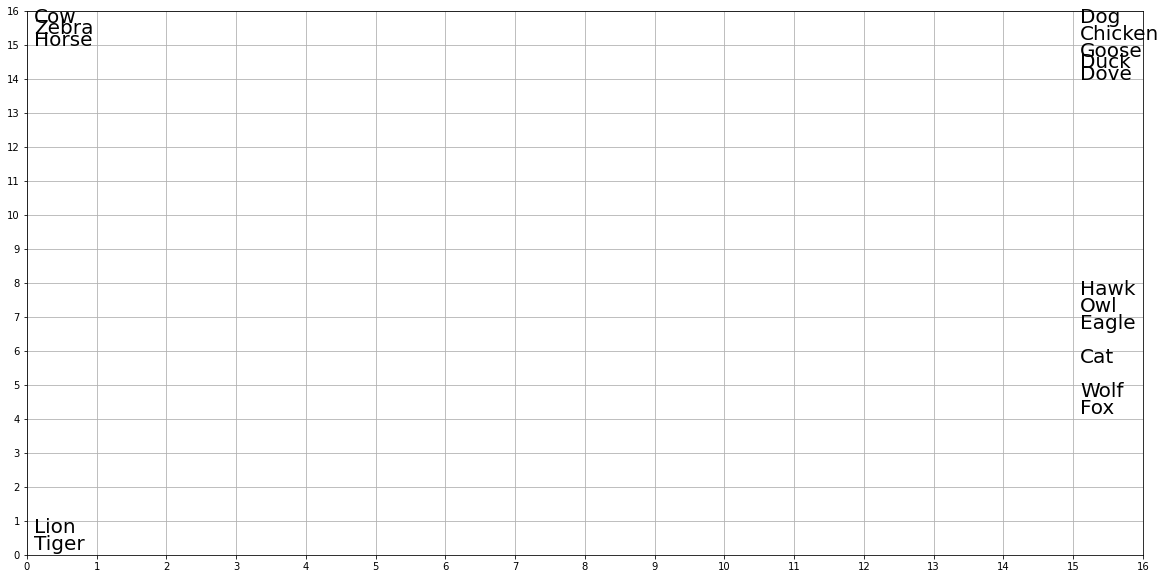

In [6]:
g = Graph()

sel = [(1, [0, 1, 2]), (1, [3, 4]), (1, [5, 6, 7, 8]), (1, [9]), (1, [9, 10, 11, 12])]

dist = g.create(Dist, props={"selections": sel})

g.connect(g.start, dist, 1)

som_size = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 3, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_legs = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 2, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_char = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 4, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_hunt = g.create(
    SOM, props={'norm': True, "size": 16, "dim": 1, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_move = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 4, "sigma": 13, "lr": 0.8, "n_iters": 10000})

g.connect(dist, som_size, 1)
g.connect(dist, som_legs, 2)
g.connect(dist, som_char, 3)
g.connect(dist, som_hunt, 4)
g.connect(dist, som_move, 5)

bmu_size = g.create(BMU, props={"output": "1D"})
bmu_legs = g.create(BMU, props={"output": "1D"})
bmu_char = g.create(BMU, props={"output": "1D"})
bmu_hunt = g.create(BMU, props={"output": "1D"})
bmu_move = g.create(BMU, props={"output": "1D"})

g.connect(som_size, bmu_size, 0)
g.connect(som_legs, bmu_legs, 0)
g.connect(som_char, bmu_char, 0)
g.connect(som_hunt, bmu_hunt, 0)
g.connect(som_move, bmu_move, 0)

concat = g.create(Concat, props={"axis": 1})

g.connect(bmu_size, concat, 1)
g.connect(bmu_legs, concat, 1)
g.connect(bmu_char, concat, 1)
g.connect(bmu_hunt, concat, 1)
g.connect(bmu_move, concat, 1)

size = 16

som = g.create(SOM, props={'pca': True, 'norm': True, 'size': size, 'dim': 5,
               "nhood": nhood_gaussian, 'sigma': 13, 'lr': 0.8, 'n_iters': 1000})

g.connect(concat, som, 1)
cal = g.create(Calibrate, props={"labels": animal})

g.connect(som, cal, 0)
g.connect(cal, g.end, 1)

g.set_input(data)

out = g.get_output()

plot_features(size, out)

### Deep SOM (1) - Using BMU coords 2D (Bubble Output SOM 16x16)

['Dove', 'Chicken', 'Owl', 'Hawk']
['Duck', 'Goose']
['Eagle']
['Fox']
['Dog']
['Wolf', 'Lion']
['Cat']
['Tiger']
['Horse', 'Zebra', 'Cow']


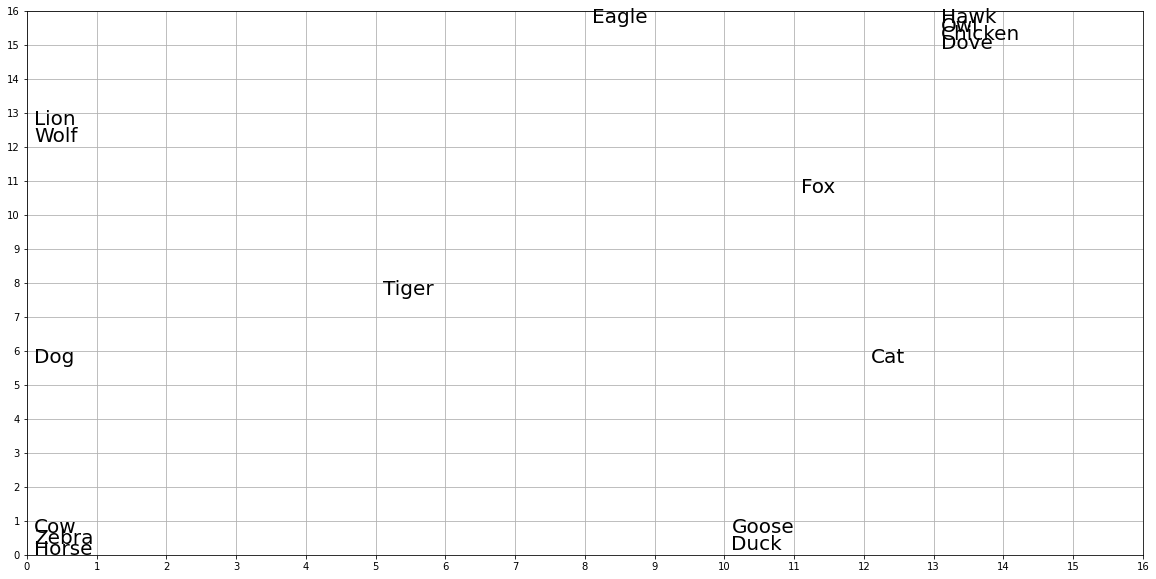

In [7]:
g = Graph()

sel = [(1, [0, 1, 2]), (1, [3, 4]), (1, [5, 6, 7, 8]), (1, [9]), (1, [9, 10, 11, 12])]

dist = g.create(Dist, props={"selections": sel})

g.connect(g.start, dist, 1)

som_size = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 3, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_legs = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 2, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_char = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 4, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_hunt = g.create(
    SOM, props={'norm': True, "size": 16, "dim": 1, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_move = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 4, "sigma": 13, "lr": 0.8, "n_iters": 10000})

g.connect(dist, som_size, 1)
g.connect(dist, som_legs, 2)
g.connect(dist, som_char, 3)
g.connect(dist, som_hunt, 4)
g.connect(dist, som_move, 5)

bmu_size = g.create(BMU, props={"output": "2D"})
bmu_legs = g.create(BMU, props={"output": "2D"})
bmu_char = g.create(BMU, props={"output": "2D"})
bmu_hunt = g.create(BMU, props={"output": "2D"})
bmu_move = g.create(BMU, props={"output": "2D"})

g.connect(som_size, bmu_size, 0)
g.connect(som_legs, bmu_legs, 0)
g.connect(som_char, bmu_char, 0)
g.connect(som_hunt, bmu_hunt, 0)
g.connect(som_move, bmu_move, 0)

concat = g.create(Concat, props={"axis": 1})

g.connect(bmu_size, concat, 1)
g.connect(bmu_legs, concat, 1)
g.connect(bmu_char, concat, 1)
g.connect(bmu_hunt, concat, 1)
g.connect(bmu_move, concat, 1)

size = 16

som = g.create(SOM, props={'pca': True, 'norm': True, 'size': size, 'dim': 10,
               "nhood": nhood_bubble, 'sigma': 13, 'lr': 0.8, 'n_iters': 10000})

g.connect(concat, som, 1)
cal = g.create(Calibrate, props={"labels": animal})

g.connect(som, cal, 0)
g.connect(cal, g.end, 1)

g.set_input(data)

out = g.get_output()

plot_features(size, out)

### Deep SOM (1) - Using BMU indices 1D (Bubble Output SOM 8x8)

['Dove', 'Duck', 'Goose']
['Chicken']
['Owl', 'Hawk', 'Eagle']
['Fox', 'Cat']
['Dog']
['Wolf']
['Tiger', 'Lion']
['Horse', 'Zebra', 'Cow']


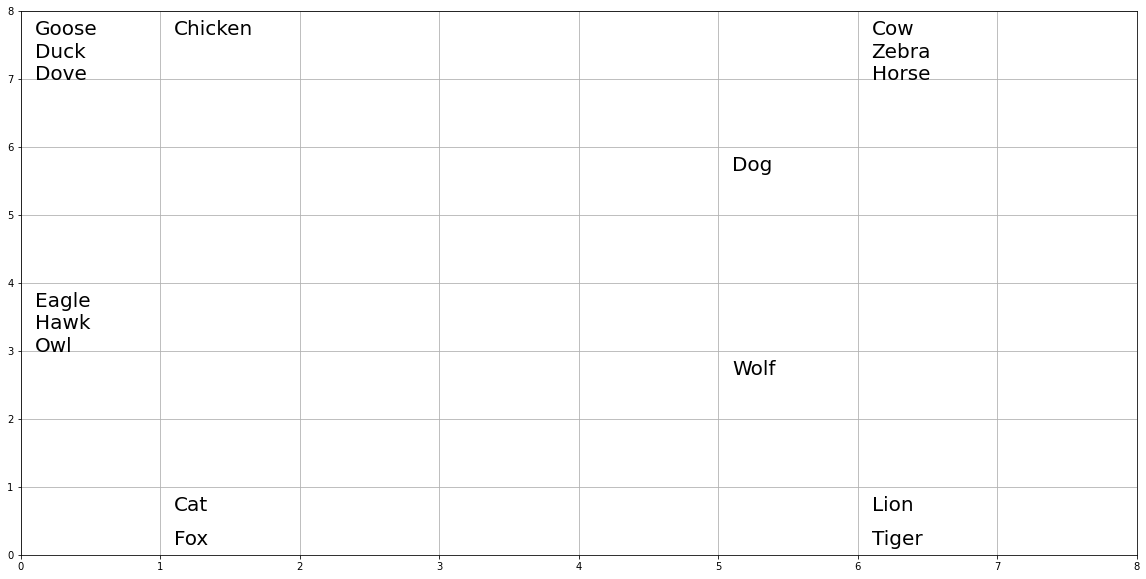

In [8]:

g = Graph()

sel = [(1, [0, 1, 2]), (1, [3, 4]), (1, [5, 6, 7, 8]), (1, [9]), (1, [9, 10, 11, 12])]

dist = g.create(Dist, props={"selections": sel})

g.connect(g.start, dist, 1)

som_size = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 3, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_legs = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 2, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_char = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 4, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_hunt = g.create(
    SOM, props={'norm': True, "size": 16, "dim": 1, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_move = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 4, "sigma": 13, "lr": 0.8, "n_iters": 10000})

g.connect(dist, som_size, 1)
g.connect(dist, som_legs, 2)
g.connect(dist, som_char, 3)
g.connect(dist, som_hunt, 4)
g.connect(dist, som_move, 5)

bmu_size = g.create(BMU, props={"output": "1D"})
bmu_legs = g.create(BMU, props={"output": "1D"})
bmu_char = g.create(BMU, props={"output": "1D"})
bmu_hunt = g.create(BMU, props={"output": "1D"})
bmu_move = g.create(BMU, props={"output": "1D"})

g.connect(som_size, bmu_size, 0)
g.connect(som_legs, bmu_legs, 0)
g.connect(som_char, bmu_char, 0)
g.connect(som_hunt, bmu_hunt, 0)
g.connect(som_move, bmu_move, 0)

concat = g.create(Concat, props={"axis": 1})

g.connect(bmu_size, concat, 1)
g.connect(bmu_legs, concat, 1)
g.connect(bmu_char, concat, 1)
g.connect(bmu_hunt, concat, 1)
g.connect(bmu_move, concat, 1)

size = 8

som = g.create(SOM, props={'size': size, 'dim': 5,
               "nhood": nhood_bubble, 'sigma': 13, 'lr': 0.7, 'n_iters': 10000})

g.connect(concat, som, 1)
cal = g.create(Calibrate, props={"labels": animal})

g.connect(som, cal, 0)
g.connect(cal, g.end, 1)

g.set_input(data)

out = g.get_output()

plot_features(size, out)

### Deep SOM (1) - Using mix of BMU coords 2D and BMU indices 1D (Mexican Output SOM 7x7) 1

['Dove', 'Chicken', 'Duck', 'Goose', 'Owl', 'Hawk', 'Eagle', 'Fox', 'Wolf', 'Cat', 'Tiger', 'Lion']
['Dog', 'Horse', 'Zebra', 'Cow']


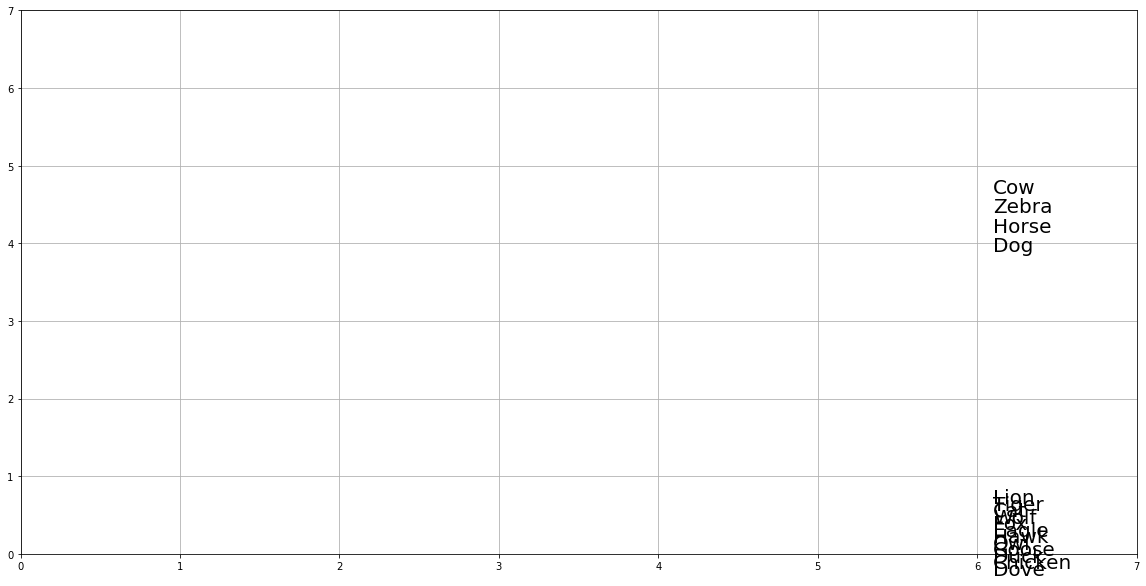

In [9]:
g = Graph()

sel = [(1, [0, 1, 2]), (1, [3, 4]), (1, [5, 6, 7, 8]), (1, [9]), (1, [9, 10, 11, 12])]

dist = g.create(Dist, props={"selections": sel})

g.connect(g.start, dist, 1)

som_size = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 3, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_legs = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 2, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_char = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 4, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_hunt = g.create(
    SOM, props={'norm': True, "size": 16, "dim": 1, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_move = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 4, "sigma": 13, "lr": 0.8, "n_iters": 10000})

g.connect(dist, som_size, 1)
g.connect(dist, som_legs, 2)
g.connect(dist, som_char, 3)
g.connect(dist, som_hunt, 4)
g.connect(dist, som_move, 5)

bmu_size = g.create(BMU, props={"output": "2D"})
bmu_legs = g.create(BMU, props={"output": "2D"})
bmu_char = g.create(BMU, props={"output": "1D"})
bmu_hunt = g.create(BMU, props={"output": "1D"})
bmu_move = g.create(BMU, props={"output": "1D"})

g.connect(som_size, bmu_size, 0)
g.connect(som_legs, bmu_legs, 0)
g.connect(som_char, bmu_char, 0)
g.connect(som_hunt, bmu_hunt, 0)
g.connect(som_move, bmu_move, 0)

concat = g.create(Concat, props={"axis": 1})

g.connect(bmu_size, concat, 1)
g.connect(bmu_legs, concat, 1)
g.connect(bmu_char, concat, 1)
g.connect(bmu_hunt, concat, 1)
g.connect(bmu_move, concat, 1)

size = 7

som = g.create(SOM, props={'pca': True, 'norm': True, 'size': size, 'dim': 7,
               "nhood": nhood_mexican, 'sigma': 13, 'lr': 0.8, 'n_iters': 10000})

g.connect(concat, som, 1)
cal = g.create(Calibrate, props={"labels": animal})

g.connect(som, cal, 0)
g.connect(cal, g.end, 1)

g.set_input(data)

out = g.get_output()

plot_features(size, out)

### Deep SOM (1) - Using mix of BMU coords 2D and BMU indices 1D (Mexican Output SOM 7x7) 2

['Dove', 'Duck', 'Goose', 'Owl', 'Hawk', 'Eagle', 'Fox', 'Wolf', 'Cat', 'Tiger', 'Lion']
['Chicken', 'Dog', 'Horse', 'Zebra', 'Cow']


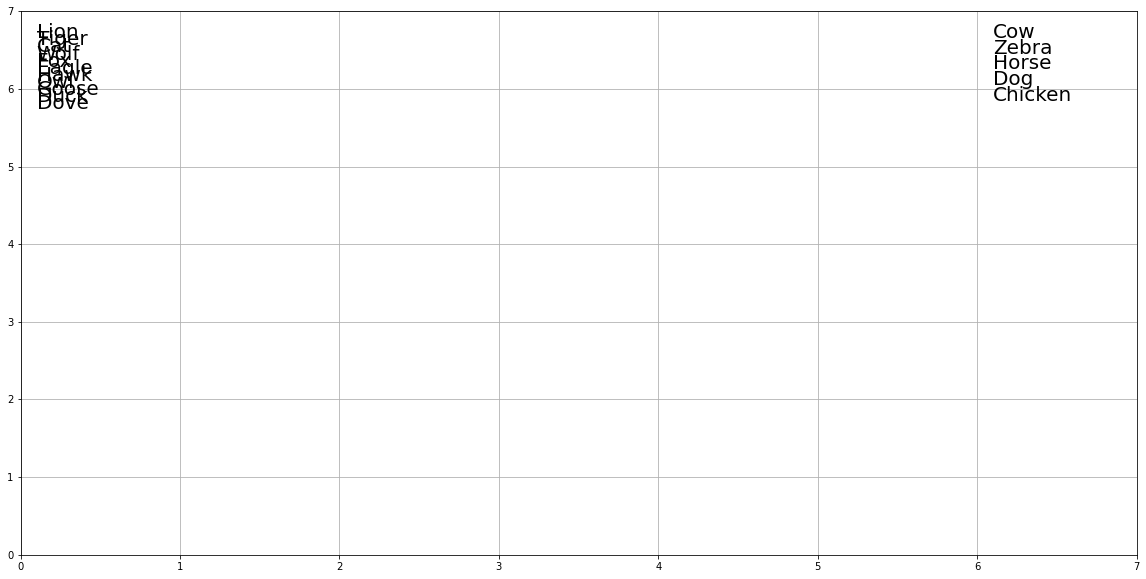

In [10]:
g = Graph()

sel = [(1, [0, 1, 2]), (1, [3, 4]), (1, [5, 6, 7, 8]), (1, [9]), (1, [9, 10, 11, 12])]

dist = g.create(Dist, props={"selections": sel})

g.connect(g.start, dist, 1)

som_size = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 3, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_legs = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 2, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_char = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 4, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_hunt = g.create(
    SOM, props={'norm': True, "size": 16, "dim": 1, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som_move = g.create(
    SOM, props={'pca': True, 'norm': True, "size": 16, "dim": 4, "sigma": 13, "lr": 0.8, "n_iters": 10000})

g.connect(dist, som_size, 1)
g.connect(dist, som_legs, 2)
g.connect(dist, som_char, 3)
g.connect(dist, som_hunt, 4)
g.connect(dist, som_move, 5)

bmu_size = g.create(BMU, props={"output": "2D"})
bmu_legs = g.create(BMU, props={"output": "1D"})
bmu_char = g.create(BMU, props={"output": "1D"})
bmu_hunt = g.create(BMU, props={"output": "2D"})
bmu_move = g.create(BMU, props={"output": "1D"})

g.connect(som_size, bmu_size, 0)
g.connect(som_legs, bmu_legs, 0)
g.connect(som_char, bmu_char, 0)
g.connect(som_hunt, bmu_hunt, 0)
g.connect(som_move, bmu_move, 0)

concat = g.create(Concat, props={"axis": 1})

g.connect(bmu_size, concat, 1)
g.connect(bmu_legs, concat, 1)
g.connect(bmu_char, concat, 1)
g.connect(bmu_hunt, concat, 1)
g.connect(bmu_move, concat, 1)

size = 7

som = g.create(SOM, props={'pca': True, 'norm': True, 'size': size, 'dim': 7,
               "nhood": nhood_mexican, 'sigma': 13, 'lr': 0.8, 'n_iters': 1000})

g.connect(concat, som, 1)
cal = g.create(Calibrate, props={"labels": animal})

g.connect(som, cal, 0)
g.connect(cal, g.end, 1)

g.set_input(data)

out = g.get_output()

plot_features(size, out)

## Deep SOM (2) - Like for Like Example, Using BMU index (Bubble 7x7)

                   *---> (small, 2leg, feather,fly,swim)--->*
                 /                                          \\
                /                                            \\
    animal -> dist --------> (med, 4leg, hair, run)-------> concat -> som -> calibrate(labels)
                \\                                             /
                 \\                                           /
                  *---> (large, 4leg, hooves, mane, hunt)--->*
    

['Dove', 'Chicken', 'Duck', 'Goose']
['Owl', 'Hawk', 'Eagle']
['Fox', 'Dog', 'Wolf', 'Tiger', 'Lion', 'Horse', 'Zebra', 'Cow']
['Cat']


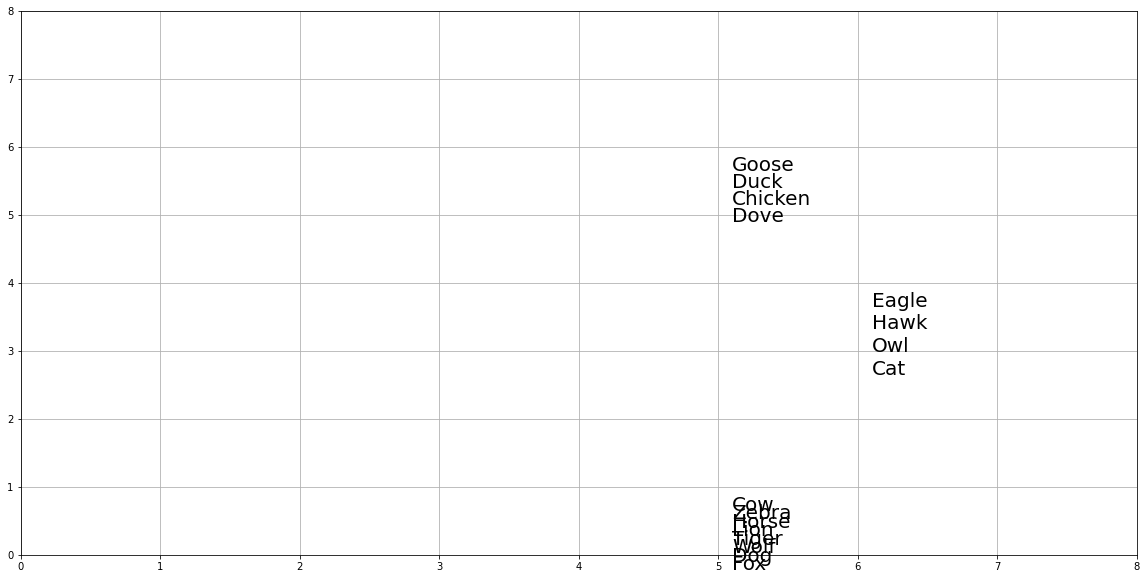

In [11]:
g = Graph()

sel = [(1, [0, 3, 8, 11, 12]), (1, [1, 4, 5, 10]), (1, [2, 4, 6, 7, 9])]

dist = g.create(Dist, props={"selections": sel})
g.connect(g.start, dist, 1)

som1 = g.create(
    SOM, props={'pca':True, "norm": True, "size": 16, "dim": 5, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som2 = g.create(
    SOM, props={'pca':True, "norm": True, "size": 16, "dim": 4, "sigma": 13, "lr": 0.8, "n_iters": 10000})
som3 = g.create(
    SOM, props={'pca':True, "norm": True, "size": 16, "dim": 5, "sigma": 13, "lr": 0.8, "n_iters": 10000})

g.connect(dist, som1, 1)
g.connect(dist, som2, 2)
g.connect(dist, som3, 3)

bmu1 = g.create(BMU, props={"output": "1D"})
bmu2 = g.create(BMU, props={"output": "1D"})
bmu3 = g.create(BMU, props={"output": "1D"})

g.connect(som1, bmu1, 0)
g.connect(som2, bmu2, 0)
g.connect(som3, bmu3, 0)

concat = g.create(Concat, props={"axis": 1})

g.connect(bmu1, concat, 1)
g.connect(bmu2, concat, 1)
g.connect(bmu3, concat, 1)

size = 8

som = g.create(SOM, props={'pca':True, "norm": True, 'size': size, 'dim': 3, 'rand_state': True,
               "nhood": nhood_mexican, 'sigma': 13, 'lr': 0.8, 'n_iters': 1000})

g.connect(concat, som, 1)

cal = g.create(Calibrate, props={"labels": animal})

g.connect(som, cal, 0)
g.connect(cal, g.end, 1)

g.set_input(data)

out = g.get_output()

plot_features(size, out)